In [1]:
import numpy as np
import p2pspatial
import pulse2percept as p2p
import skimage.io as skio
import skimage.transform as skit
import scipy.stats as sps
import scipy.interpolate as spi

%matplotlib inline
import matplotlib.pyplot as plt

/home/mbeyeler/anaconda3/lib/python3.5/site-packages/skvideo/__init__.py:356: UserWarning: avconv/avprobe not found in path: 
  warnings.warn("avconv/avprobe not found in path: " + str(path), UserWarning)
2018-01-10 17:09:44,784 [pulse2percept] [INFO] Welcome to pulse2percept


In [2]:
argus = p2p.implants.ArgusII(eye='RE', rot=np.deg2rad(-45))

In [3]:
sim = p2pspatial.SpatialSimulation(argus)
sim.set_optic_fiber_layer(sampling=250)
sim.set_ganglion_cell_layer()

In [4]:
model_params = {'loc_od': (15.5, 1.5),
                'csmode': 'gaussian',
                'cswidth': 100.0,
                'sensitivity_rule': 'decay',
                'scoring_weights': [1, 1, 1, 1]}
sim.set_params(**model_params)

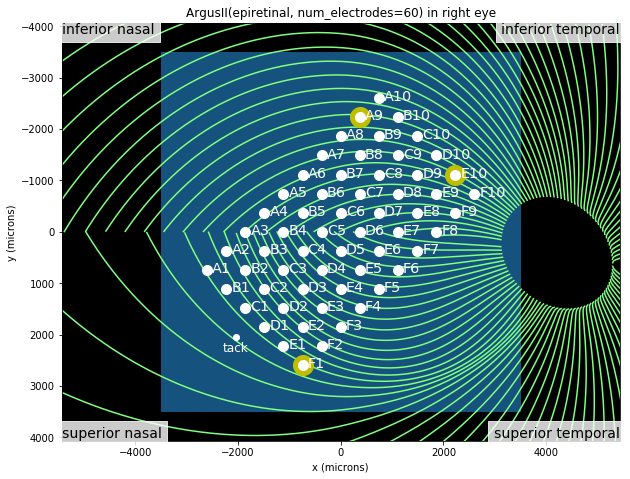

In [5]:
sim.plot_fundus(stim={'F1': 0, 'A9': 0, 'E10': 0}, upside_down=True);

In [6]:
def cart2pol(x, y):
    theta = np.arctan2(y, x)
    rho = np.hypot(x, y)
    return theta, rho

def pol2cart(theta, rho):
    x = rho * np.cos(theta)
    y = rho * np.sin(theta)
    return x, y

In [7]:
def calc_displacement(r, meridian='temporal'):
    alpha = np.where(meridian == 'temporal', 1.8938, 2.4607)
    beta = np.where(meridian == 'temporal', 2.4598, 1.7463)
    gamma = np.where(meridian == 'temporal', 0.91565, 0.77754)
    delta = np.where(meridian == 'temporal', 14.904, 15.111)
    mu = np.where(meridian == 'temporal', -0.09386, -0.15933)
    scale = np.where(meridian == 'temporal', 12.0, 10.0)
    
    rmubeta = (np.abs(r) - mu) / beta
    numer = delta * gamma * np.exp(-rmubeta ** gamma) * rmubeta ** (alpha * gamma - 1)
    denom = beta * sps.gamma.pdf(alpha, 5)

    return numer / denom / scale

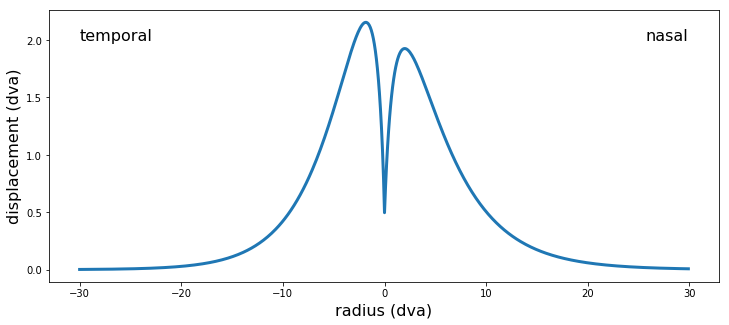

In [8]:
x = np.arange(-30, 30, 0.1)
plt.figure(figsize=(12, 5))
plt.plot(x, calc_displacement(np.abs(x), meridian=np.where(x < 0, 'temporal', 'nasal')),
         linewidth=3);
plt.xlabel('radius (dva)', fontsize=16)
plt.ylabel('displacement (dva)', fontsize=16)
plt.text(x[0], 2.0, 'temporal', ha='left', fontsize=16)
plt.text(x[-1], 2.0, 'nasal', ha='right', fontsize=16)
plt.savefig('displace.png')

In [9]:
def displace(xy, eye='RE'):
    """In: retinal surface coords (um), Out: visual field coords (dva)"""
    if eye == 'LE':
        # Let's not think about eyes right now...
        raise NotImplementedError
    
    # Convert x, y (um) into polar coordinates
    theta, rho_ret = cart2pol(xy[:, 0], xy[:, 1])
    
#     rho_ret = np.where(rho_ret < 350 / 2.0, np.nan, rho_ret)
    
    # Convert radius from um to dva
    rho_dva = p2p.retina.ret2dva(rho_ret)
    
    # Add displacement
    meridian = np.where(xy[:, 0] < 0, 'temporal', 'nasal')
    rho_dva += calc_displacement(rho_dva, meridian=meridian)
    
    # Convert back to x, y (dva)
    x, y = pol2cart(theta, rho_dva)
    
    return np.vstack((x, y)).T

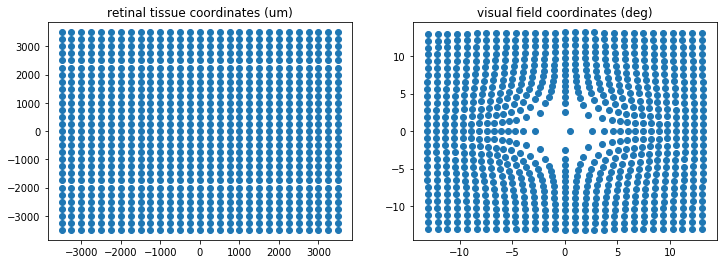

In [10]:
plt.figure(figsize=(12, 4))

plt.subplot(121)
plt.scatter(sim.ofl.gridx, sim.ofl.gridy)
plt.title('retinal tissue coordinates (um)')

plt.subplot(122)
xy = np.vstack((sim.ofl.gridx.ravel(), sim.ofl.gridy.ravel())).T
xynew = displace(xy)
plt.scatter(xynew[:, 0], xynew[:, 1])
plt.title('visual field coordinates (deg)')
plt.savefig('ret-dva.png')

In [11]:
# There should be no output points in the foveola
np.any(np.sqrt(xynew[:, 0] ** 2 + xynew[:, 1] ** 2) < calc_displacement(0))

False

In [12]:
def inv_displace(xy, eye='RE'):
    """In: visual field coords (dva), Out: retinal surface coords (um)"""
    if eye == 'LE':
        # Let's not think about eyes right now...
        raise NotImplementedError
    
    nasal_in = np.arange(0, 30, 0.1)
    nasal_out = nasal_in + calc_displacement(nasal_in, meridian='nasal')
    inv_displace_nasal = spi.interp1d(nasal_out, nasal_in, bounds_error=False)

    temporal_in = np.arange(0, 30, 0.1)
    temporal_out = temporal_in + calc_displacement(temporal_in, meridian='temporal')
    inv_displace_temporal = spi.interp1d(temporal_out, temporal_in, bounds_error=False)
    
    # Convert x, y (dva) into polar coordinates
    theta, rho_dva = cart2pol(xy[:, 0], xy[:, 1])
    
    # Add inverse displacement
    rho_dva = np.where(xy[:, 0] < 0, inv_displace_temporal(rho_dva),
                       inv_displace_nasal(rho_dva))
    
    # Convert radius from um to dva
    rho_ret = p2p.retina.dva2ret(rho_dva)
    
    # Convert back to x, y (dva)
    x, y = pol2cart(theta, rho_ret)
    
    return np.vstack((x, y)).T

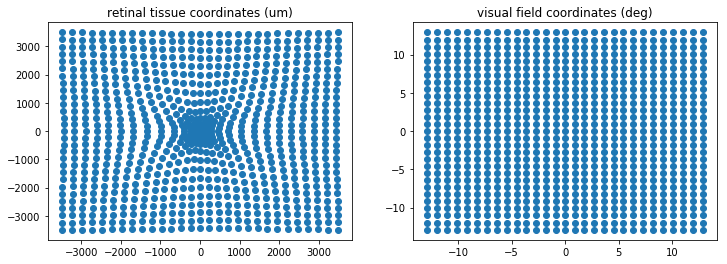

In [13]:
plt.figure(figsize=(12, 4))

plt.subplot(121)
xy = np.vstack((sim.ofl.gridx.ravel(), sim.ofl.gridy.ravel())).T
xynew = inv_displace(p2p.retina.ret2dva(xy))
plt.scatter(xynew[:, 0], xynew[:, 1])
plt.title('retinal tissue coordinates (um)')

plt.subplot(122)
plt.scatter(p2p.retina.ret2dva(sim.ofl.gridx), p2p.retina.ret2dva(sim.ofl.gridy))
plt.title('visual field coordinates (deg)')
plt.savefig('dva-ret.png')

In [14]:
def inv_warp(xy, img_shape=None):
    # From output img coords to output dva coords
    x_out_range = (-30, 30)
    y_out_range = (-20, 20)
    xy_dva = xy
    xy_dva[:, 0] = x_out_range[0] + xy[:, 0] / img_shape[1] * np.diff(x_out_range)
    xy_dva[:, 1] = y_out_range[0] + xy[:, 1] / img_shape[0] * np.diff(y_out_range)
    
    # From output dva coords ot input ret coords
    xy_ret = inv_displace(xy_dva)
    
    # From input ret coords to input img coords
    x_in_range = p2p.retina.dva2ret(x_out_range)
    y_in_range = p2p.retina.dva2ret(y_out_range)
    xy_img = xy_ret
    xy_img[:, 0] = (xy_ret[:, 0] - x_in_range[0]) / np.diff(x_in_range) * img_shape[1]
    xy_img[:, 1] = (xy_ret[:, 1] - y_in_range[0]) / np.diff(y_in_range) * img_shape[0]
    return xy_img

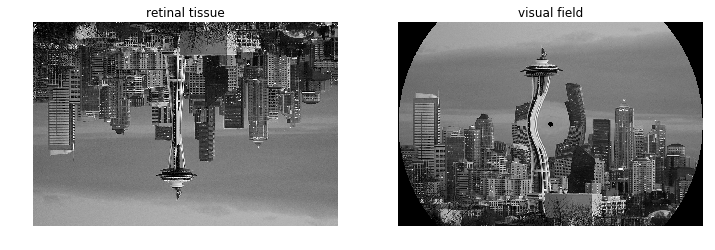

In [20]:
plt.figure(figsize=(12, 4))

plt.subplot(121)
img = skio.imread('seattle.jpg', as_grey=True)
plt.imshow(np.flipud(img), cmap='gray')
plt.title('retinal tissue')
plt.axis('off')

plt.subplot(122)
plt.imshow(skit.warp(img, inv_warp, map_args={'img_shape': img.shape}), cmap='gray')
plt.title('visual field')
plt.axis('off')
plt.savefig('seattle_ret-dva.png')

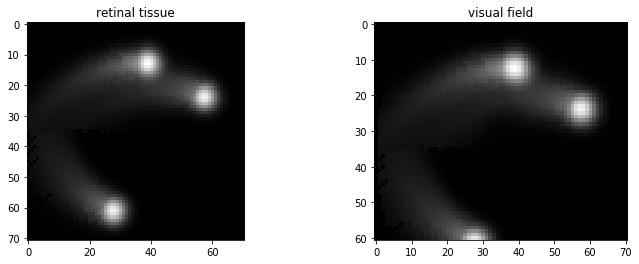

In [16]:
plt.figure(figsize=(12, 4))

plt.subplot(121)
sim.cswidth = 300
sim.set_optic_fiber_layer(sampling=100, decay_const=1)
sim.ecs = {}
sim.set_params(use_persp_trafo=False, use_ofl=True)
img = sim.pulse2percept('F1_A9_E10', 20.0)
plt.imshow(img, cmap='gray')
plt.axis('equal')
plt.axis('image')
plt.title('retinal tissue')

plt.subplot(122)
img = sim.pulse2percept('F1_A9_E10', 20.0)
plt.imshow(skit.warp(img, inv_warp, output_shape=(61, 71), 
                     map_args={'img_shape': img.shape}), cmap='gray')
plt.axis('equal')
plt.axis('image')
plt.title('visual field')

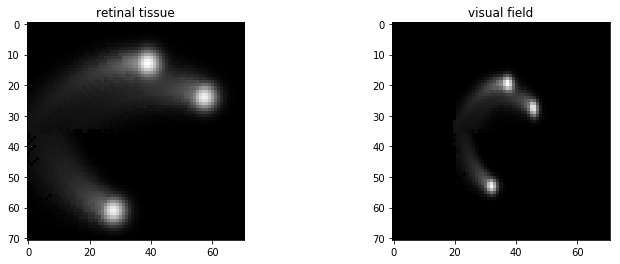

In [17]:
plt.figure(figsize=(12, 4))

plt.subplot(121)
sim.cswidth = 300
sim.set_params(use_persp_trafo=False)
sim.set_optic_fiber_layer(sampling=100, decay_const=1)
sim.ecs = {}
img = sim.pulse2percept('F1_A9_E10', 20.0)
plt.imshow(img, cmap='gray')
plt.axis('equal')
plt.axis('image')
plt.title('retinal tissue')

plt.subplot(122)
sim.set_params(use_persp_trafo=True, out_x_range=(-30, 30), out_y_range=(-20, 20))
sim.ecs = {}
img = sim.pulse2percept('F1_A9_E10', 20.0)
plt.imshow(img, cmap='gray')
plt.axis('equal')
plt.axis('image')
plt.title('visual field')